In [13]:
import torch
import numpy as np
import seaborn as sns

In [18]:
import sklearn.metrics as M

In [2]:
model = torch.load("../models/optimized_model.pth")

In [3]:
def nparams(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [68]:
import os
def getsize(filepath):
    return f"{os.path.getsize(filepath) / (1024 * 1024.0):.4f} MB"

In [74]:
getsize('distil.pth')

'28.4763 MB'

In [5]:
from model import SentimentClassifier

from data_utils import tokenization
from data_utils.preprocess import process_tweet

torch.nn.functional.tanh = torch.tanh

thresholds = {'anger': 0.55, 'disgust': 0.34500000000000003, 'fear': 0.8150000000000001, 'happiness': 0.17, 'sadness': 0.37, 'surprise': 0.295}

def eval_fn(model, tokenizer, preprocess_fn, text):
    ids = tokenizer.EncodeAsIds(text, preprocess_fn).tokenization
    length = len(ids)
    
    input_text = torch.from_numpy(np.array(ids, dtype=np.int64))
    input_text = torch.unsqueeze(input_text, -1)
    
    input_tsteps = torch.from_numpy(np.array(length-1, dtype=np.int64))
    input_tsteps = torch.unsqueeze(input_tsteps, -1)
    
    with torch.no_grad():
        class_out = model(input_text, input_tsteps)
    classes = ['anger', 'no-print', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'no-print']
    result = []
    for i, prob in enumerate(class_out[0][0]):
        if classes[i] == 'no-print':
            continue
        result.append(prob.item() > thresholds[classes[i]])
        
    return np.array(result)

In [6]:
tokenizer = tokenization.SentencePieceTokenizer(model_path="../models/ama_32k_tokenizer.model")

In [7]:
from tqdm import tqdm

In [8]:
import pandas as pd

In [9]:
test = pd.read_csv("../data/test.csv")

In [10]:
X = test.Tweet.values

In [11]:
test.head()

,Tweet,anger,disgust,fear,happiness,sadness,surprise
0,@Adnan__786__ @AsYouNotWish Dont worry Indian ...,1,0,0,0,0,0
1,"Academy of Sciences, eschews the normally sobe...",0,1,0,0,0,0
2,I blew that opportunity -__- #mad,1,1,0,0,1,0
3,This time in 2 weeks I will be 30... 😥,0,0,0,1,1,0
4,#Deppression is real. Partners w/ #depressed p...,0,0,1,0,1,0


In [14]:
y = test.iloc[:, 1:].values

In [37]:
def evaluate_model(model, tokenizer=tokenizer, texts=X, y_true=y, n_splits=25):
    y_pred = [eval_fn(model, tokenizer, preprocess_fn=process_tweet, text=txt) for txt in tqdm(X)]
    y_pred = np.stack(y_pred)
    f1_macros  = []
    f1_micros  = []
    accuracies = []
    for true, pred in zip(np.array_split(y_true, n_splits), np.array_split(y_pred, n_splits)):
        f1_macros.append(M.f1_score(true, pred, average='macro'))
        f1_micros.append(M.f1_score(true, pred, average='micro'))
        accuracies.append(M.accuracy_score(true, pred))
    
    return np.array(f1_macros), np.array(f1_micros), np.array(accuracies)

In [38]:
macro, micro, acc = evaluate_model(model)

100%|██████████| 3259/3259 [02:44<00:00, 19.87it/s]


In [26]:
def present(macro, micro, acc):
    print(f"MacroF1:  {macro.mean():.4f} +- {macro.std():.4f}")
    print(f"MicroF1:  {micro.mean():.4f} +- {micro.std():.4f}")
    print(f"Accuracy: {acc.mean():.4f} +- {acc.std():.4f}")

In [47]:
present(macro, micro, acc)

MacroF1:  0.6630 +- 0.0295
MicroF1:  0.7434 +- 0.0206
Accuracy: 0.4554 +- 0.0444


In [32]:
import torch.quantization as Q
import torch.nn as nn

In [33]:
qmodel = Q.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

In [39]:
qmacro, qmicro, qacc = evaluate_model(qmodel)

100%|██████████| 3259/3259 [04:55<00:00, 11.02it/s]


In [46]:
present(qmacro, qmicro, qacc)

MacroF1:  0.6637 +- 0.0290
MicroF1:  0.7437 +- 0.0197
Accuracy: 0.4548 +- 0.0443


In [49]:
import matplotlib.pylab as plt

In [66]:
def plot_two(one, two):
    _ = plt.figure(figsize=(15.0, 15.0))
    sns.kdeplot(one, color='red')
    sns.kdeplot(two, color='blue')

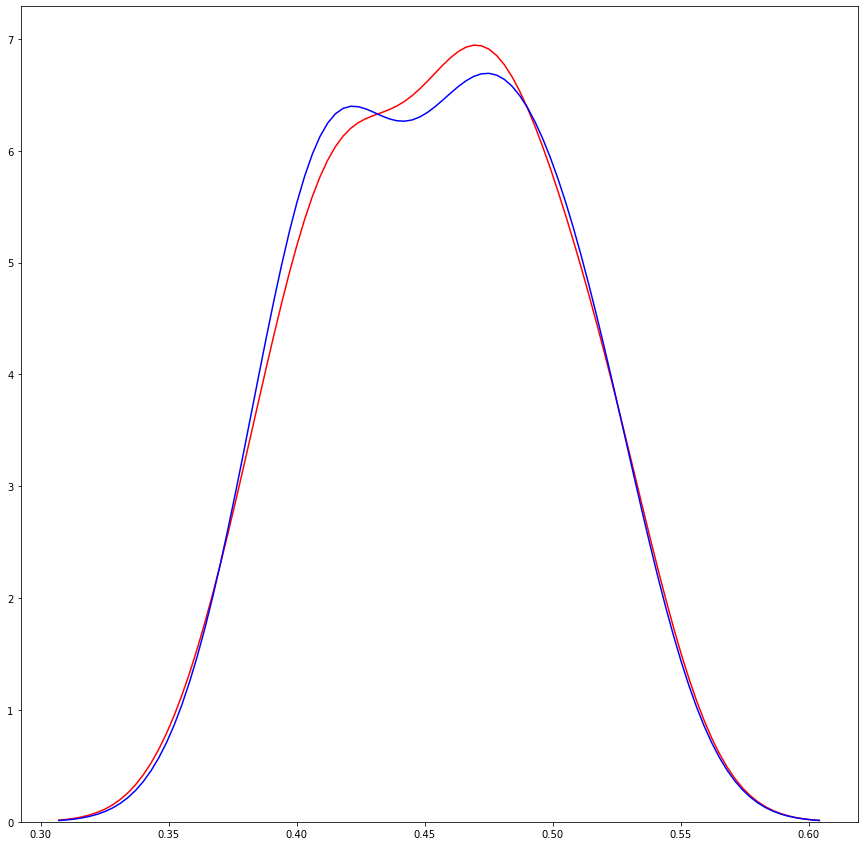

In [67]:
plot_two(acc, qacc)

In [36]:
from scipy.stats import wilcoxon

In [40]:
wilcoxon(macro, qmacro)

WilcoxonResult(statistic=95.0, pvalue=0.30646485459506156)

In [41]:
wilcoxon(micro, qmicro)

WilcoxonResult(statistic=76.0, pvalue=0.44450890263539566)

In [44]:
wilcoxon(acc, qacc)

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=15.0, pvalue=0.37215383020417214)